<a href="https://colab.research.google.com/github/fantaxiah/Dissertation/blob/main/ODmeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
# Assuming you have a DataFrame 'df' with columns 'pH' and 'absorption'
# Replace 'your_data.csv' with the actual file or data source

file_to_read = '/content/meanOleicNov-Dec2023_Kiara&Carlos.csv'
# Read your data into a DataFrame
df = pd.read_csv(file_to_read)

column_name = 'absorption_mean'
# Find the maximum value in the 'absorption' column
max_absorption = df[column_name].max()

# Perform Min-Max normalization on the 'absorption' column
df['normalized_absorption'] = df[column_name] / max_absorption

# Display the DataFrame with normalized 'absorption'
print(df[['pH', 'normalized_absorption']])

      pH  normalized_absorption
0   12.0               0.275268
1   11.0               0.187494
2   10.5               0.087961
3   10.0               0.209473
4    9.5               0.205786
5    9.0               0.334624
6    8.8               0.347877
7    8.6               0.447037
8    8.5               0.354410
9    8.4               0.386141
10   8.2               0.396407
11   8.0               0.618992
12   7.8               0.452403
13   7.6               0.506766
14   7.5               0.321979
15   7.4               0.915539
16   7.2               1.000000
17   7.0               0.780261
18   6.5               0.407606
19   6.0               0.463019
20   5.5               0.060896
21   5.0               0.339437


In [ ]:
# Filter out data with pH values less than 6
df_filt = df[df['pH'] > 3]

# Calculate standard deviation
std_dev = df_filt['normalized_absorption'].std()

print(df_filt)

      pH  absorption_mean  normalized_absorption
0   12.0         0.393267               0.275268
1   11.0         0.267867               0.187494
2   10.5         0.125667               0.087961
3   10.0         0.299267               0.209473
4    9.5         0.294000               0.205786
5    9.0         0.478067               0.334624
6    8.8         0.497000               0.347877
7    8.6         0.638667               0.447037
8    8.5         0.506333               0.354410
9    8.4         0.551667               0.386141
10   8.2         0.566333               0.396407
11   8.0         0.884333               0.618992
12   7.8         0.646333               0.452403
13   7.6         0.724000               0.506766
14   7.5         0.460000               0.321979
15   7.4         1.308000               0.915539
16   7.2         1.428667               1.000000
17   7.0         1.114733               0.780261
18   6.5         0.582333               0.407606
19   6.0         0.6

In [ ]:
# Sigmoid function from Sean's paper
def sigmoid(x, a, b, c):
    return a / (1 + np.exp((a * x) + b))

# Fit sigmoid curve
# Initial guesses for parameters a, b, and c
# initial_guesses = [1, 0, 0]
initial_guess = [max(df_filt['normalized_absorption']), 1, np.median(df_filt['pH'])]

# Fit sigmoid curve to the normalized absorption data
params, covariance = curve_fit(sigmoid, df_filt['pH'], df_filt['normalized_absorption'], p0=initial_guess, maxfev=20000, method='trf')
# No arguments passed to reflect uncertainty in normalized absorption, sum((f_bar-f)^2/SE^2)

In [ ]:
# Number of bootstrap samples
num_samples = 2000
bootstrap_params = np.zeros((num_samples, len(params)))

for i in range(num_samples):
    indices = np.random.choice(len(df_filt['pH']), len(df_filt['pH']), replace=True)
    x_bootstrap = df_filt['pH'].iloc[indices]
    y_bootstrap = df_filt['normalized_absorption'].iloc[indices]
    bootstrap_params[i, :], _ = curve_fit(sigmoid, x_bootstrap, y_bootstrap)

confidence_interval = np.percentile(bootstrap_params, [15, 85], axis=0)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Generate a finer set of x-values for the plot
fine_pH_values = np.linspace(df_filt['pH'].min(), df_filt['pH'].max(), 1000)

# Predicted values using the fitted parameters for the finer set of x-values
fine_sigmoid_fit = sigmoid(fine_pH_values, *params)

# Create a new DataFrame with the fine_pH_values and corresponding fine_sigmoid_fit
df_fine = pd.DataFrame({'pH': fine_pH_values, 'sigmoid_fit': fine_sigmoid_fit})

# Round the 'pH' values in both DataFrames
df_filt.loc[:, 'pH_rounded'] = df_filt['pH'].round(5).astype(float)
df_fine.loc[:, 'pH_rounded'] = df_fine['pH'].round(5).astype(float)

# Merge the new DataFrame with the original DataFrame on the 'pH' column
df_merged = pd.merge(df_filt, df_fine, on='pH_rounded', how='left')

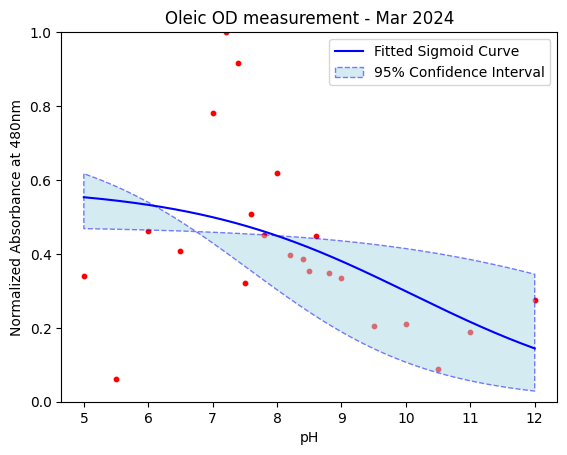

In [ ]:
# Plot the filtered data and the fitted sigmoid curve with higher resolution
plt.scatter(df_filt['pH'], df_filt['normalized_absorption'], s=10, color='red')
plt.plot(fine_pH_values, fine_sigmoid_fit, label='Fitted Sigmoid Curve', color='blue')

# Add a shaded area for the 95% confidence interval
plt.fill_between(fine_pH_values, sigmoid(fine_pH_values, *confidence_interval[0]), sigmoid(fine_pH_values, *confidence_interval[1]), color='lightblue', linestyle='dashed', linewidth=1, edgecolor='blue', alpha=0.5, label='95% Confidence Interval')

plt.title('Oleic OD measurement - Mar 2024')
plt.xlabel('pH')
plt.ylabel('Normalized Absorbance at 480nm')

# Set y-axis limits to be no greater than 1
plt.ylim(0, 1)

plt.legend()
plt.show()

In [ ]:
# Compute the second derivative of the sigmoid function
def sigmoid_second_derivative(x, a, b):
    return (a ** 2) * np.exp((a * x) + b) / ((1 + np.exp((a * x) + b)) ** 3)

# Fit sigmoid curve
params, covariance = curve_fit(sigmoid, df_filt['pH'], df_filt['normalized_absorption'], p0=initial_guess)

# Extract fitted parameters
a, b, c = params

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
# Find inflection point
inflection_x = -b / a  # The inflection point occurs where the first derivative is zero
inflection_y = sigmoid(inflection_x, a, b, c)  # Compute corresponding y-value

# Print inflection point
print("pH of estimated vesicle creation:", inflection_x)

pH of estimated vesicle creation: 10.091747060285735


At every bootstrap sample get parameter estimates